# Application Installation Prediction

## Problem Description
A problem which focus on online advertising. The dataset corresponds to impressions of users and ads from ShareChat + Moj app, where each impression (a set of 80 features) is an advertisement (ad) that was shown to a user and whether that resulted in a click or an install of the application corresponding to the advertisement. The problem is to predict the probability of an impression resulting in application installation.

## Solution Overview
The solution leverages a novel feature classification method to categorize anonymous features into different groups and apply enhanced feature engineering and graph neural networks to reveal underlying information and improve prediction accuracy. This solution can also be generalized to other privacy preserving recommendation systems.

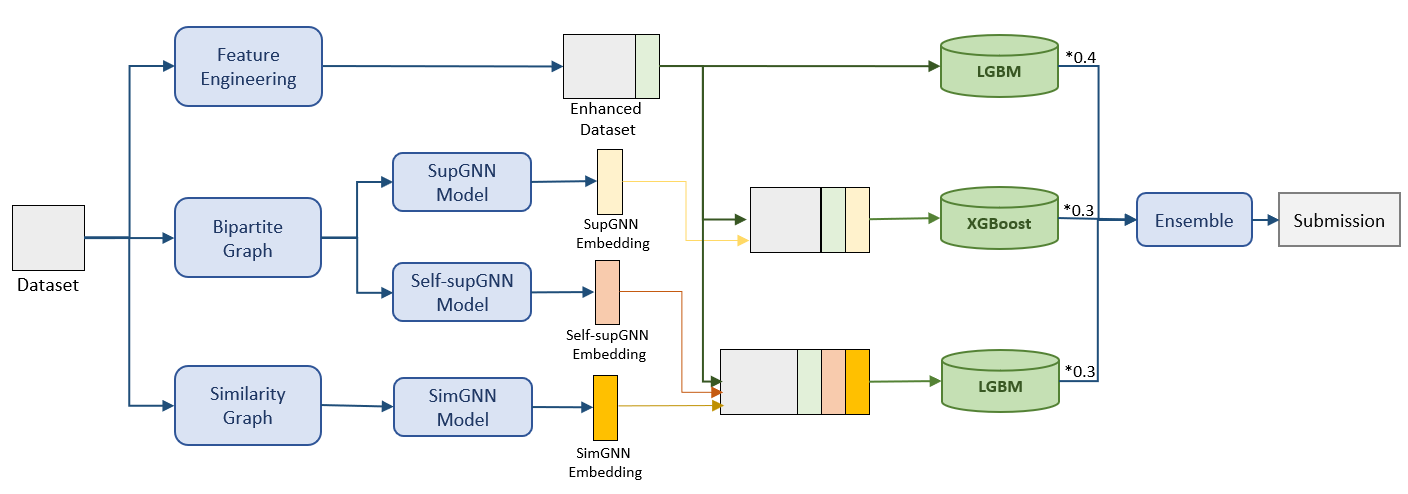

## Getting Started

### Step 1: Prepare the dataset
- Download the RecSys Challenge 2023 dataset from the official [website](https://sharechat.com/recsys2023/login)

### Step 2: Prepare the environment

```
export WORKDIR="YOUR PATH FOR recsys_refkits"
export USECASE_PATH=${WORKDIR}"/usecases/1_app_installation_pred/"
mkdir -p ${USECASE_PATH}/dataset; cd dataset; unzip sharechat.zip
```

### Step 3: Training the model
- Trigger training using the following command

In [1]:
! export USECASE_PATH=`pwd`; export WORKDIR=${USECASE_PATH}/../../; cd ${WORKDIR}/recsys_kit/models/lightgbm/docker; docker-compose up classic-ml-train

Recreating lgbm-container ... 
Attaching to lgbm-containerdone
lgbm-container      | WARNING: Running pip as the 'root' user can result in broken permissions and conflicting behaviour with the system package manager. It is recommended to use a virtual environment instead: https://pip.pypa.io/warnings/venv
get_indexing_feature: 100%|██████████| 21/21 [01:06<00:00,  3.16s/it]
lgbm-container      |  ########################## begin training ##########################
lgbm-container      | Training started ...
lgbm-container      | /usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
lgbm-container      |   _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
lgbm-container      | [LightGBM] [Info] Number of positive: 588239, number of negative: 2799641
lgbm-container      | [LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.169474 seconds.
lgbm-c

### Step 4: Update trained model to model repository 

In this step, we will update the model archive folder with our latest trained model.
```
cp ${USECASE_PATH}/output/models/lgbm_trained_HPO1.mdl ${USECASE_PATH}/model_store/prediction/1/model.txt
```

### Step 5: launch serving
- Start Triton Inference Server, GRPCInferenceService at 0.0.0.0:8001, HTTPService at 0.0.0.0:8000

```
export WORKDIR="YOUR DIR"
export USECASE_PATH=${WORKDIR}"/usecases/1_app_installation_pred/"
cd ${WORKDIR}/recsys-kits/serve/triton_serve/docker
docker-compose up -d triton-server-cpu
```

### Step 6: Client Test

#### 6.1 Check if serving model is ready

In [2]:
! no_proxy="127.0.0.1" curl -X POST "http://127.0.0.1:8000/v2/repository/index"

[{"name":"app_install_pred","version":"1","state":"READY"},{"name":"postprocessing","version":"1","state":"READY"},{"name":"prediction","version":"1","state":"READY"},{"name":"preprocessing","version":"1","state":"READY"}]

#### 6.2 single request test

In [3]:
# 1. prepare request
import pandas as pd
USECASE_PATH="."
valid_dataset = f"{USECASE_PATH}/dataset/valid/valid.csv"
valid_df = pd.read_csv(valid_dataset, sep = ',')

valid_df = valid_df[:1]

body = {
  "id" : "1",
  "inputs" : [{"name": "input__0", "data": valid_df.values.tolist(), "datatype": "FP32", 'shape': [valid_df.shape[0], 82]}],
  "outputs" : [{"name" : "output__0"}]
}

# interact with inference server
import json
import requests
triton_infer_uri = "http://127.0.0.1:8000/v2/models/app_install_pred/versions/1/infer"

resp = requests.post(
    triton_infer_uri,
    data=json.dumps(body),
    headers={"content-type": "application/json"},
    proxies={"http": None, "https": None}
)

response_dict = resp.json()
if 'outputs' not in response_dict:
    print(response_dict)
else:
    result_out = []
    recommended_items = []
    for item in response_dict['outputs']:
        if item['name'] == 'output__0':
            result_out = item['data']
    for out in result_out:
        print(f"For User Query, Install probability is: {out}")

For User Query, Install probability is: 0.03684486448764801


#### 6.3 Inference with entire valid

In [ ]:
! pip install scikit-learn

In [7]:
import pandas as pd
import numpy as np
import json

WORKDIR="YOUR PATH FOR recsys_refkits"
USECASE_PATH=f"{WORKDIR}/usecases/1_app_installation_pred/"
valid_dataset = f"{USECASE_PATH}/dataset/valid/valid.csv"
valid_df = pd.read_csv(valid_dataset, sep = ',')

valid_df = valid_df[:256]
gt = valid_df['is_installed']

body = {
  "id" : "1",
  "inputs" : [{"name": "input__0", "data": valid_df.values.tolist(), "datatype": "FP32", 'shape': [valid_df.shape[0], 82]}],
  "outputs" : [{"name" : "output__0"}]
}

# interact with inference server
import json
import requests
triton_infer_uri = "http://127.0.0.1:8000/v2/models/app_install_pred/versions/1/infer"

resp = requests.post(
    triton_infer_uri,
    data=json.dumps(body),
    headers={"content-type": "application/json"},
    proxies={"http": None, "https": None}
)

# print(resp.json())
prediction = []
for output in resp.iter_lines(decode_unicode=True):
    output = json.loads(output)
    prediction.extend([float(i) for i in output['outputs'][0]['data']])

# evaluate
from sklearn.metrics import log_loss, roc_auc_score
eval_loss = log_loss(gt, np.array(prediction))
auc = roc_auc_score(gt, np.array(prediction))

print(f'eval_loss: {eval_loss:.3f}, auc: {auc:.3f}')

eval_loss: 0.324, auc: 0.868
